In [611]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from clean.Cleaning import str_to_date
import numpy as np
from scipy.stats import chi2_contingency as chi2_contingency
from sklearn.feature_selection import chi2
import warnings 
warnings.filterwarnings("ignore")

In [701]:
df_product= pd.read_csv(r'data/CURATED/produit_clean.csv', encoding="UTF8")
df_client= pd.read_csv(r'data/CURATED/client_clean.csv', encoding="UTF8")
df= pd.read_csv(r'data/CURATED/data_clean.csv', encoding="UTF8")

In [702]:
df['age']=2022 - df['birth']
df_client['age']=2022 - df_client['birth']

In [703]:
df['full_date'] = df['date'].astype('datetime64')
df=df.drop(columns=['date'])
df['date'] = df['full_date'].dt.date.astype('datetime64')
df['time'] = df['full_date'].dt.time

# Analyse 

## 1-Distribution

### A-Clients 

In [860]:
fig = px.pie(df_client, names='sex', title='percentage of clients by sex',width=400, height=400)
fig.show()

print("-> The customer base contains {} including: .".format(df_client.count()[0]))
print("-> {} of clients are women .".format(df_client[(df_client.sex == 'f')].count()[0]))
print("-> {} of clients are men .".format(df_client[(df_client.sex == 'm')].count()[0]))
pie.savefig("percentage_of_clients_by_sex.png")

-> The customer base contains 8621 including: .
-> 4490 of clients are women .
-> 4131 of clients are men .


skw:
 0.360813881775354
kur:
 -0.636664753633164


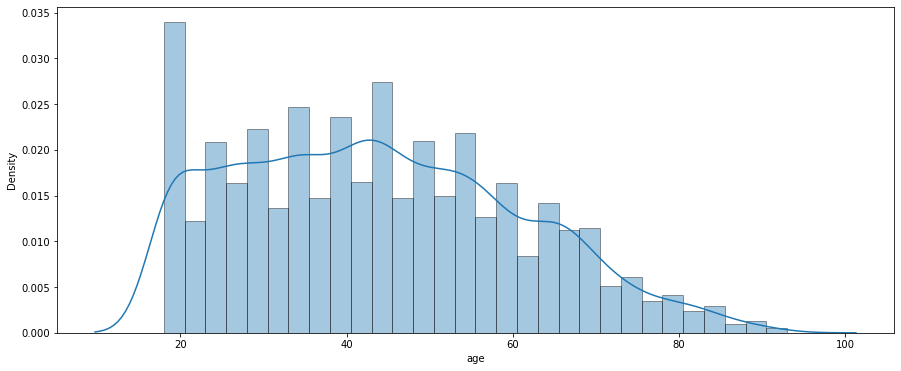

In [632]:
plt.figure(figsize=(15, 6))
g=sns.distplot(df_client['age'], hist_kws = {'edgecolor':'black'})
print("skw:\n",df_client['age'].skew())
print("kur:\n",df_client['age'].kurtosis())

In [601]:
#verify nb of purchase per client
df.value_counts(subset=['client_id']).reset_index(name="count").head()

,client_id,count
0,c_1609,12855
1,c_6714,4471
2,c_3454,3273
3,c_4958,2562
4,c_7959,195


-> we find 4 customers that we consider as resellers in relation to the number of high purchases during a year, so we decide to discard them then study them separately

In [704]:
df_pro = df[(df['client_id']=='c_1609') | (df['client_id']=='c_6714') | (df['client_id']=='c_3454') | (df['client_id']=='c_4958')].reset_index(drop = True)
df = df[(df['client_id']!='c_1609') & (df['client_id']!='c_6714') & (df['client_id']!='c_3454') & (df['client_id']!='c_4958')].reset_index(drop = True)

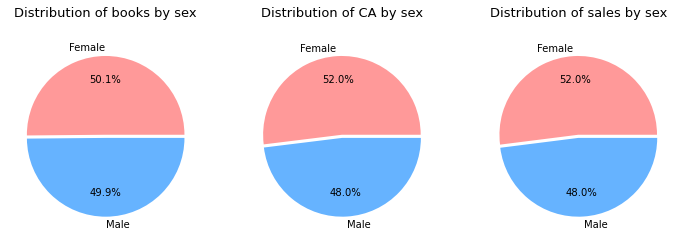

In [669]:
pie_books_s = df.groupby("sex")['id_prod'].nunique()
pie_sales_s = df.groupby("sex")['categ'].count()
pie_CA_s = df.groupby("sex")['price'].sum()

fig, ax = plt.subplots(1, 3)
labels = ["Female", "Male"]

ax[0].pie(pie_books_s, labels=labels, autopct="%.1f%%", explode=[0.02]*2, pctdistance=0.7, colors = ['#ff9999','#66b3ff'])
ax[0].set_title("Distribution of books by sex\n", fontsize=13)

ax[1].pie(pie_CA_s, labels=labels, autopct="%.1f%%", explode=[0.02]*2, pctdistance=0.7, colors = ['#ff9999','#66b3ff'])
ax[1].set_title("Distribution of CA by sex\n", fontsize=13)

ax[2].pie(pie_sales_s, labels=labels, autopct="%.1f%%", explode=[0.02]*2, pctdistance=0.7, colors = ['#ff9999','#66b3ff'])
ax[2].set_title("Distribution of sales by sex\n", fontsize=13)

pie.savefig("SexDistributionPieChart.png")

In [670]:
print ("-> {} books bought by women .".format(df[(df.sex == 'f')].count()[0]))
print ("-> {} books bought by men .".format(df[(df.sex == 'm')].count()[0]))
print('')
print ("->  {} € is the contribution of women to turnover.".format(round(df.price[(df.sex == 'f')].sum(),2)))
print ("->  {} € is the contribution of men to turnover.".format(round(df.price[(df.sex == 'm')].sum(),2)))
print('')
print('women age disstribution  : ')
print ("-> age min is {} years, age max is {} years, age mean is {} years.".format(df.age[df['sex']=='f'].min(),df.age[df['sex']=='f'].max(),round(df.age[df['sex']=='f'].mean(),2)))
print('')
print('men  : ')
print ("-> age min is {} years, age max is {} years, age mean is {} years.".format(df.age[df['sex']=='m'].min(),df.age[df['sex']=='m'].max(),round(df.age[df['sex']=='m'].mean(),2)))
print('')

-> 163102 books bought by women .
-> 150549 books bought by men .

->  2785924.43 € is the contribution of women to turnover.
->  2576748.53 € is the contribution of men to turnover.

women age disstribution  : 
-> age min is 18 years, age max is 93 years, age mean is 44.48 years.

men  : 
-> age min is 18 years, age max is 93 years, age mean is 43.91 years.



##### -> There is a uniform distribution between sex in terms of number of customers and age, but in terms of  purchase volume and contribution to turnover is slightly different (more for women)

age distribution by sex and category


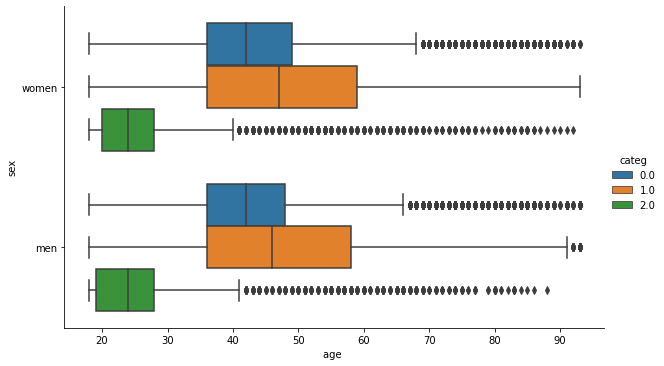

In [655]:
g = sns.catplot(y="sex", x="age", hue="categ", kind="box", data=df, height=5, aspect=8/5)
g.set_axis_labels("age ", "sex")
g.set_yticklabels(["women", "men"])
print('age distribution by sex and category')

-> we find a uniform distribution between sex and age in terms of category, same distribution of age for men and women compared to the different category

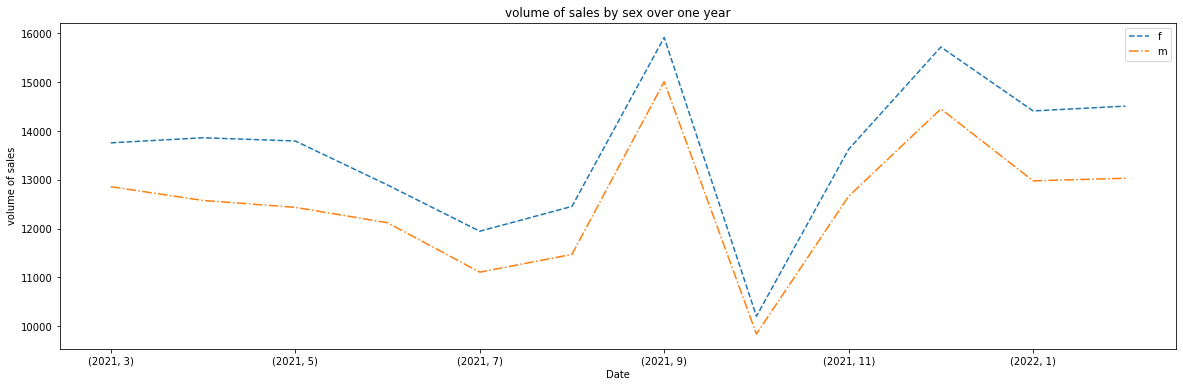

In [644]:
plt.figure(figsize = (20, 6))
df[df['sex']=='f'].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="--")
df[df['sex']=='m'].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="-.")
plt.title('volume of sales by sex over one year')
plt.xlabel('Date')
plt.ylabel('volume of sales')
plt.legend('fm') 

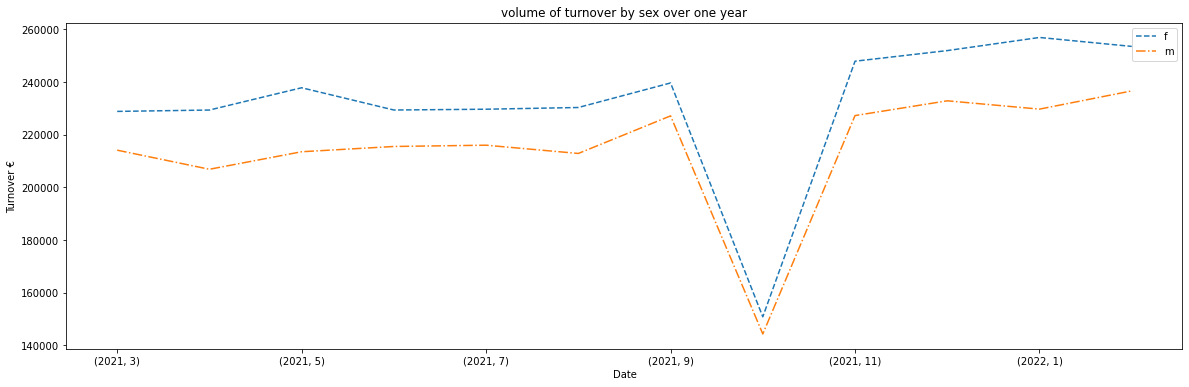

In [643]:
plt.figure(figsize = (20, 6))
df[df['sex']=='f'].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="--")
df[df['sex']=='m'].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-.")
plt.title('volume of turnover by sex over one year')
plt.xlabel('Date')
plt.ylabel('Turnover €')
plt.legend('fm') 

-> the same sales volume and contribution to turnover between men and women over time one Year 

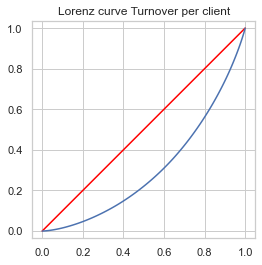

In [843]:
depense = pd.DataFrame(df.groupby("client_id")['price'].sum()).reset_index()
dep = depense['price'].values
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig=plt.figure(1,figsize=(4,4))
plt.xlim=([0,1])
plt.ylim=([0,1])
x = np.linspace(0, 1, len(lorenz))
plt.plot(x, x, color='red', ls="-")
plt.axes().axis('equal')
xaxis = np.linspace(0, 1, len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title('Lorenz curve Turnover per client')
plt.show()

In [445]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/len(lorenz) # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.4397750494636161

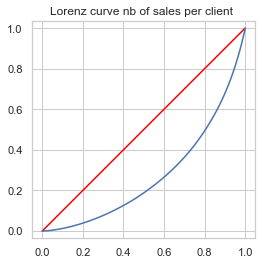

In [842]:
depense = pd.DataFrame(df.value_counts(subset=['client_id']).reset_index(name="count"))
dep = depense['count'].values
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig=plt.figure(1,figsize=(4,4))
plt.xlim=([0,1])
plt.ylim=([0,1])
x = np.linspace(0, 1, len(lorenz))
plt.plot(x, x, color='red', ls="-")
plt.axes().axis('equal')
xaxis = np.linspace(0, 1, len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title('Lorenz curve nb of sales per client ')
plt.show()

In [653]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/len(lorenz) # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.4593420517388902

-> 50% of turnover is achieved by around 20% of customers

-> 50% of nb of sales is achieved by around 20% of customers

### B-Product (catalog)

Text(0.5, 1.0, "price of catalog's Book distribution by category")

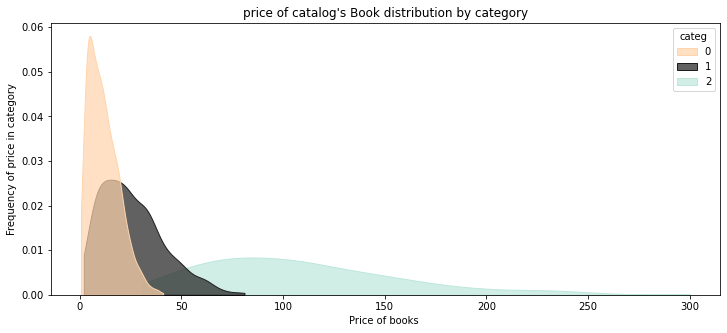

In [681]:
plt.rcParams["figure.figsize"]=12,5
g=sns.kdeplot(data=df_product, x="price", hue="categ", cut=0, fill=True, palette='icefire_r', common_norm=False, alpha =0.7)
g.set_xlabel('Price of books ')
g.set_ylabel('Frequency of price in category')
g.set_title("price of catalog's Book distribution by category")

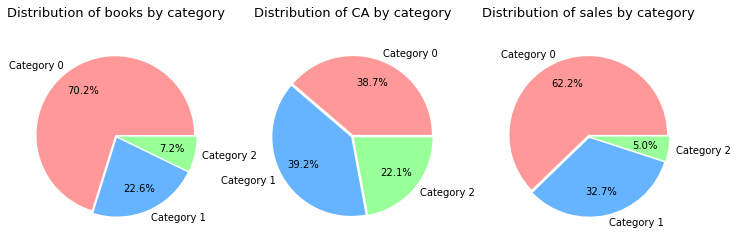

In [667]:
pie_books = df.groupby("categ")['id_prod'].nunique()
pie_sales = df.groupby("categ")['client_id'].count()
pie_CA = df.groupby("categ")['price'].sum()

fig, ax = plt.subplots(1, 3)
labels = ["Category 0", "Category 1", "Category 2"]
ax[0].pie(pie_books, labels=labels, autopct="%.1f%%", explode=[0.02]*3, pctdistance=0.7, 
          colors = ['#ff9999','#66b3ff','#99ff99'])
ax[0].set_title("Distribution of books by category\n", fontsize=13)

ax[1].pie(pie_CA, labels=labels, autopct="%.1f%%", explode=[0.02]*3, pctdistance=0.7, 
          colors = ['#ff9999','#66b3ff','#99ff99'])
ax[1].set_title("Distribution of CA by category\n", fontsize=13)

ax[2].pie(pie_sales, labels=labels, autopct="%.1f%%", explode=[0.02]*3, pctdistance=0.7, 
          colors = ['#ff9999','#66b3ff','#99ff99'])
ax[2].set_title("Distribution of sales by category\n", fontsize=13)

pie.savefig("CategoryDistributionPieChart.png")

In [666]:
print("The catalog contains {} books including : ".format(df_product.count()[0]))
print("")
print("->  {} books in category 0 .".format(df_product[(df_product.categ == 0)].count()[0]))
print("->  {} books in category 1 .".format(df_product[(df_product.categ == 1)].count()[0]))
print("->  {} books in category 2 .".format(df_product[(df_product.categ == 2)].count()[0]))
print("")
print ("->  {} books sold in category 0 .".format(df[(df.categ == 0)].count()[0]))
print ("->  {} books sold in category 1 .".format(df[(df.categ == 1)].count()[0]))
print ("->  {} books sold in category 2 .".format(df[(df.categ == 2)].count()[0]))
print("")
print ("->  {} € is the turnover achieved by books in the category 0 .".format(round(df.price[(df.categ == 0)].sum(),2)))
print ("->  {} € is the turnover achieved by books in the category 1 .".format(round(df.price[(df.categ == 1)].sum(),2)))
print ("->  {} € is the turnover achieved by books in the category 2 .".format(round(df.price[(df.categ == 2)].sum(),2)))

The catalog contains 3286 books including : 

->  2308 books in category 0 .
->  739 books in category 1 .
->  239 books in category 2 .

->  195171 books sold in category 0 .
->  102625 books sold in category 1 .
->  15756 books sold in category 2 .

->  2077605.01 € is the turnover achieved by books in the category 0 .
->  2101585.34 € is the turnover achieved by books in the category 1 .
->  1183482.61 € is the turnover achieved by books in the category 2 .


Text(0.5, 1.0, 'the age of client of each category')

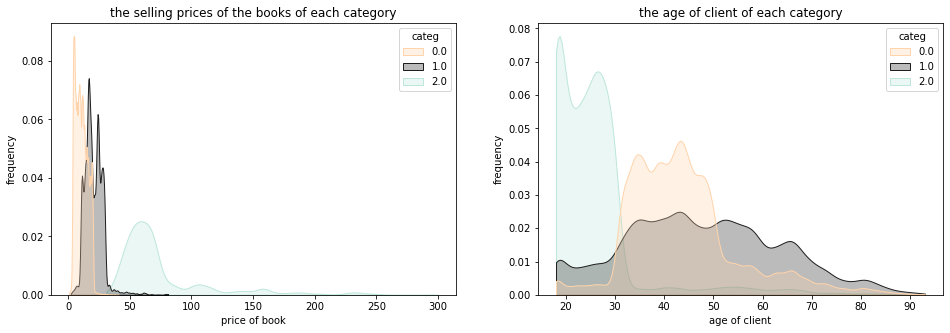

In [680]:
f, ax = plt.subplots(1,2,figsize=(16,5))
sns.kdeplot(data=df ,x="price", hue="categ",cut=0 ,fill=True, palette='icefire_r',common_norm=False, alpha =0.3,ax=ax[0])
ax[0].set_xlabel('price of book')
ax[0].set_ylabel('frequency')
sns.kdeplot(data=df ,x="age", hue="categ",cut=0 ,fill=True, palette='icefire_r',common_norm=False, alpha =0.3,ax=ax[1])
ax[1].set_xlabel('age of client')
ax[1].set_ylabel('frequency')
ax[0].set_title('the selling prices of the books of each category')
ax[1].set_title('the age of client of each category')

Book's price distribution by sex and category


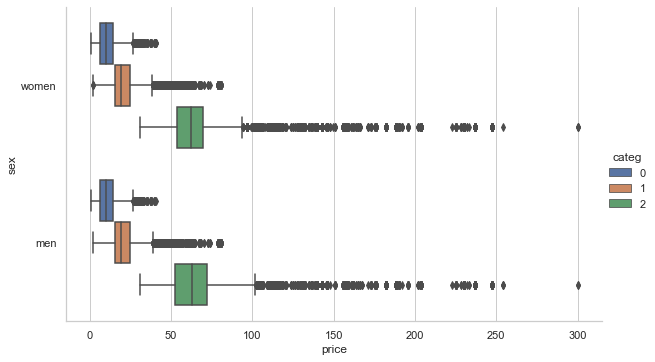

In [839]:
g = sns.catplot(y="sex", x="price", hue="categ", kind="box", data=df, height=5, aspect=8/5)
g.set_axis_labels("price" , "sex")
g.set_yticklabels(["women", "men"])
print("Book's price distribution by sex and category")

In [683]:
print('Category 0 : ')
print('')
print ("-> price min est {}€, price max est {}€, price mean est {}€.".format(df.price[df['categ']==0].min(),df.price[df['categ']==0].max(),round(df.price[df['categ']==0].mean(),2)))
print ("-> age min is {} years, age max is {} years, age mean is {} years.".format(df.age[df['categ']==0].min(),df.age[df['categ']==0].max(),df.age[df['categ']==0].mean()))
print('')
print('Category 1 : ')
print('')
print ("-> price min est {}€, price max est {}€, price mean est {}€.".format(df.price[df['categ']==1].min(),df.price[df['categ']==1].max(),df.price[df['categ']==1].mean()))
print ("-> age min is {} years, age max is {} years, age mean is {} years.".format(df.age[df['categ']==1].min(),df.age[df['categ']==1].max(),df.age[df['categ']==1].mean()))
print('')
print('Category 2 : ')
print('')
print ("-> price min est {}€, price max est {}€, price mean est {}€.".format(df.price[df['categ']==2].min(),df.price[df['categ']==2].max(),df.price[df['categ']==2].mean()))
print ("-> age min is {} years, age max is {} years, age mean is {} years.".format(df.age[df['categ']==2].min(),df.age[df['categ']==2].max(),df.age[df['categ']==2].mean()))

Category 0 : 

-> price min est 0.62€, price max est 40.99€, price mean est 10.65€.
-> age min is 18 years, age max is 93 years, age mean is 43.799575756644174 years.

Category 1 : 

-> price min est 2.0€, price max est 80.99€, price mean est 20.478298075515564€.
-> age min is 18 years, age max is 93 years, age mean is 47.813856272838 years.

Category 2 : 

-> price min est 30.99€, price max est 300.0€, price mean est 75.11313848692225€.
-> age min is 18 years, age max is 92 years, age mean is 25.75120588981975 years.


#### remark

-> Category 0 contains 70% of the books in the catalog, represents 62% of sales, but with an average price of around €11, it contributes only 38% of turnover, more bought by 30 to 50 years old people than athores.


-> Category 1 contains 22% of the books in the catalog, represents 32% of sales, with an average price of around €20, it contributes only 39% of turnover, bought by all age groups.

-> Category 2 contains 8% of the books in the catalog, represents 6% of sales, with an average price of around €75, it contributes only 23% of turnover, specially bought by young people.



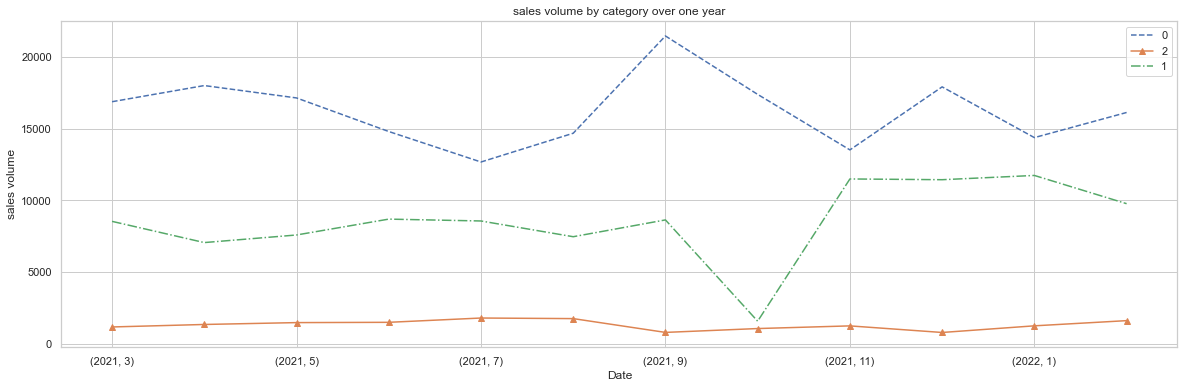

In [841]:
plt.figure(figsize = (20, 6))
df[df['categ']==0].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="--")
df[df['categ']==2].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="-^")
df[df['categ']==1].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="-.")
plt.title('sales volume by category over one year')
plt.xlabel('Date')
plt.ylabel('sales volume')
plt.legend(df.categ) 

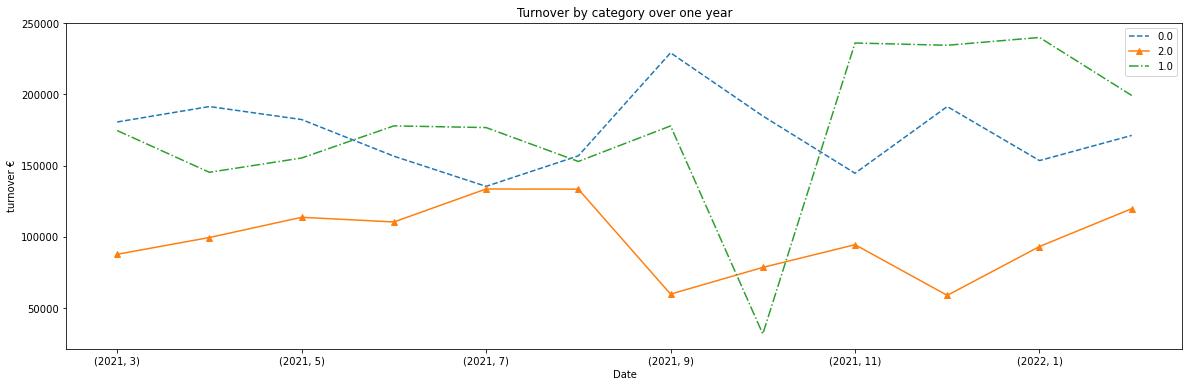

In [684]:
plt.figure(figsize = (20, 6))
df[df['categ']==0].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="--")
df[df['categ']==2].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-^")
df[df['categ']==1].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-.")
plt.title('Turnover by category over one year')
plt.xlabel('Date')
plt.ylabel('turnover €')
plt.legend(df.categ) 

-> a fairly substantial drop in sales in October for category 1 and 2 due to a slight drop in sales since the prices of category 2 are high, which brings down the overall turnover.

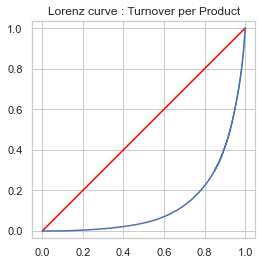

In [849]:
depense = pd.DataFrame(df.groupby("id_prod")['price'].sum()).reset_index()
dep = depense['price'].values
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

fig=plt.figure(1,figsize=(4,4))
plt.xlim=([0,1])
plt.ylim=([0,1])
x = np.linspace(0, 1, len(lorenz))
plt.plot(x, x, color='red', ls="-")
plt.axes().axis('equal')
xaxis = np.linspace(0, 1, len(lorenz)) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title('Lorenz curve : Turnover per Product')
plt.show()

In [850]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/len(lorenz) 
S = 0.5 - AUC
gini = 2*S
gini

0.7374147088462257

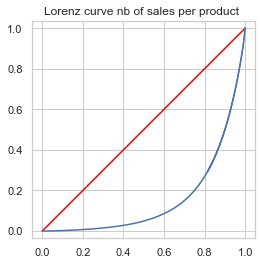

In [845]:
depense = pd.DataFrame(df.value_counts(subset=['id_prod']).reset_index(name="count"))
dep = depense['count'].values
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz)

fig=plt.figure(1,figsize=(4,4))
plt.xlim=([0,1])
plt.ylim=([0,1])
x = np.linspace(0, 1, len(lorenz))
plt.plot(x, x, color='red', ls="-")
plt.axes().axis('equal')
xaxis = np.linspace(0, 1, len(lorenz)) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.title('Lorenz curve nb of sales per product ')
plt.show()

In [582]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/len(lorenz)
S = 0.5 - AUC
gini = 2*S
gini

0.6923849683632866

-> 80% of turnover is achieved by around 20% of product

-> 70% of nb of sales is achieved by around 20% of product

### C- Sales

##### Number of sales 

Text(0.5, 1.0, ' Number of sales by sex and age')

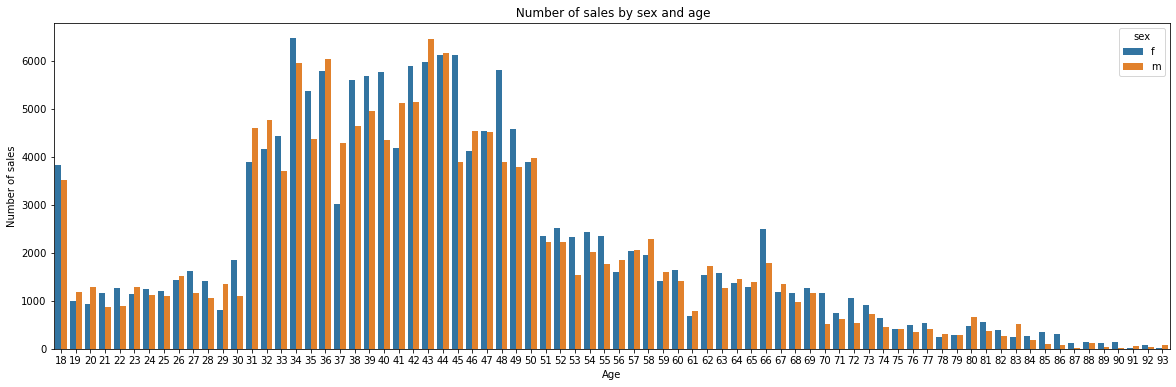

In [542]:
plt.figure(figsize = (20, 6))
g=sns.countplot(x='age', hue='sex', data=df)
g.set(xlabel="Age", ylabel = "Number of sales")
g.set_title(' Number of sales by sex and age')

Text(0.5, 1.0, ' number of sales by category and age')

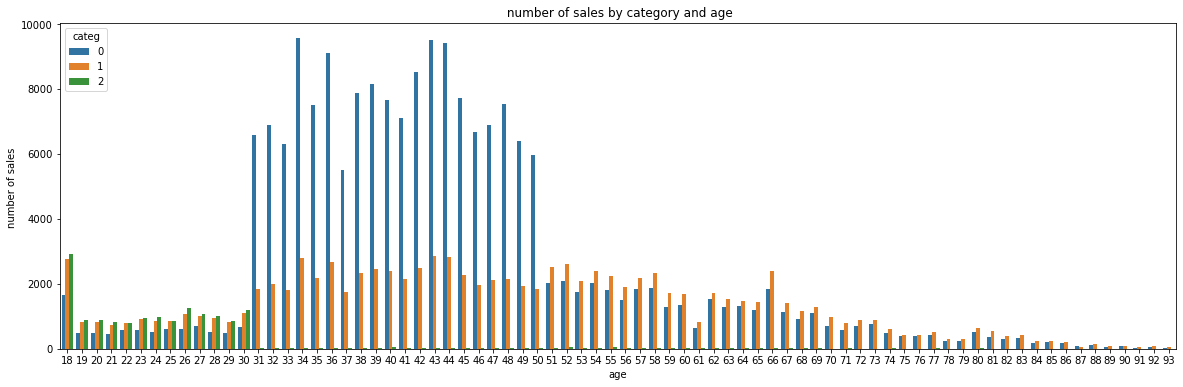

In [543]:
plt.figure(figsize = (20, 6))
g=sns.countplot(x='age', hue='categ', data=df)
g.set(xlabel="age", ylabel = "number of sales ")
g.set_title(' number of sales by category and age')

Text(0.5, 1.0, ' number of sales by category and sex')

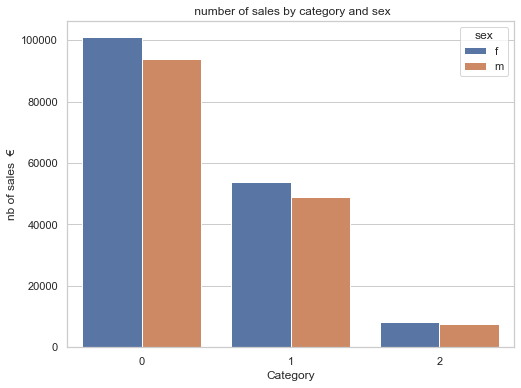

In [833]:
plt.figure(figsize = (8, 6))
g=sns.countplot(x='categ', hue='sex', data=df)
g.set(xlabel="Category", ylabel = "nb of sales  €")
g.set_xticklabels(["0", "1", "2"])
g.set_title(' number of sales by category and sex')

Text(0, 0.5, 'volume of sales')

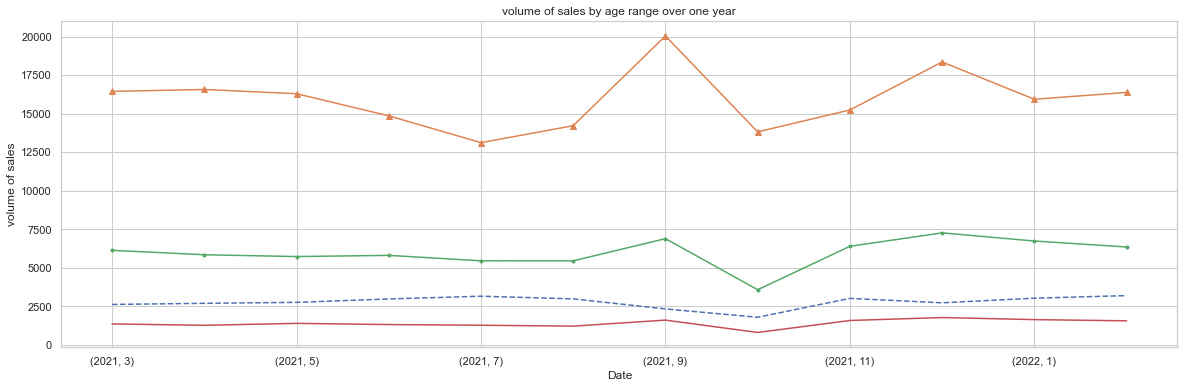

In [832]:
plt.figure(figsize = (20, 6))
df[(df['age']<30)].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="--")
df[(df['age']>=30) & (df['age']<50)].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style="^-")
df[(df['age']>=50) & (df['age']<70)].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot(style=".-")
df[(df['age']>=70)].id_prod.groupby([df.date.dt.year,df.date.dt.month]).count().plot()
plt.title('volume of sales by age range over one year')
plt.xlabel('Date')
plt.ylabel('volume of sales')

Text(0.5, 1.0, ' nb of sales contribution by age')

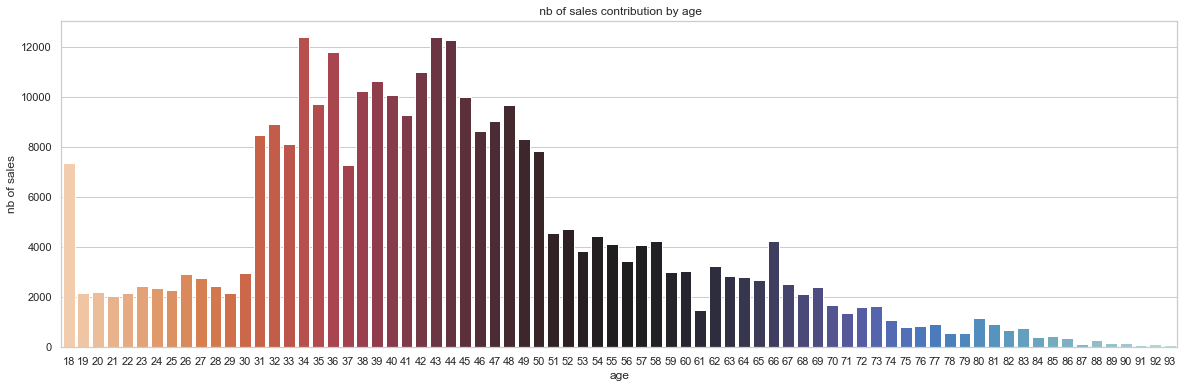

In [829]:
sales_age = df.groupby('age')['id_prod'].count().reset_index(name="nb_of_sales")
plt.figure(figsize = (20, 6))
g=sns.barplot(x='age', y="nb_of_sales", data=sales_age, palette='icefire_r')
g.set(xlabel="age", ylabel = "nb of sales")
g.set_title(' nb of sales contribution by age')

-> The 30-50 age group who orders the most books, mainly in category 0 more or less uniformly between women and men with a peak in September.

-> Those under 30 years old order books in a uniform way on the 3 categories, with the same volume between women and men but they are the majority buyers of category 2


### Turnover

Text(0.5, 1.0, ' Turnover by sex and age')

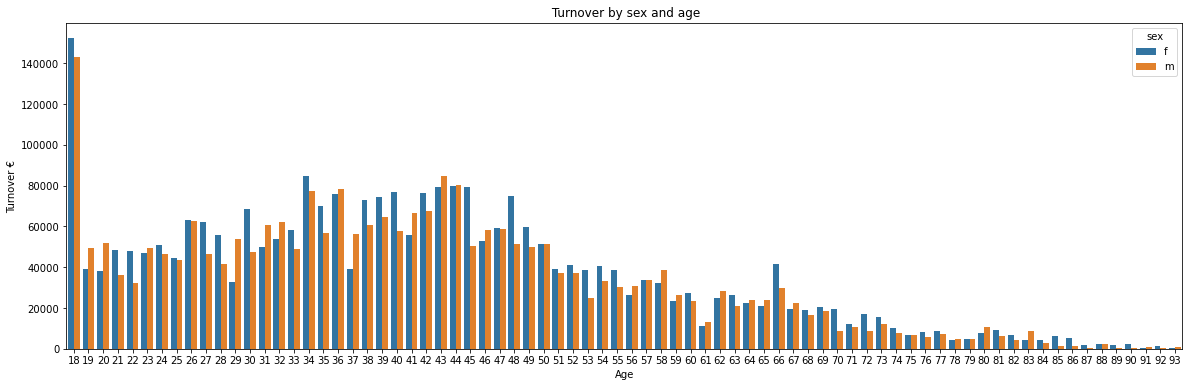

In [562]:
u=df.groupby(["age","sex"])['price'].sum().reset_index()
plt.figure(figsize = (20, 6))
g=sns.barplot(x='age', y='price', hue='sex', data=u)
g.set(xlabel="Age", ylabel = "Turnover €")
g.set_title(' Turnover by sex and age')

Text(0.5, 1.0, ' Turnover by category and age')

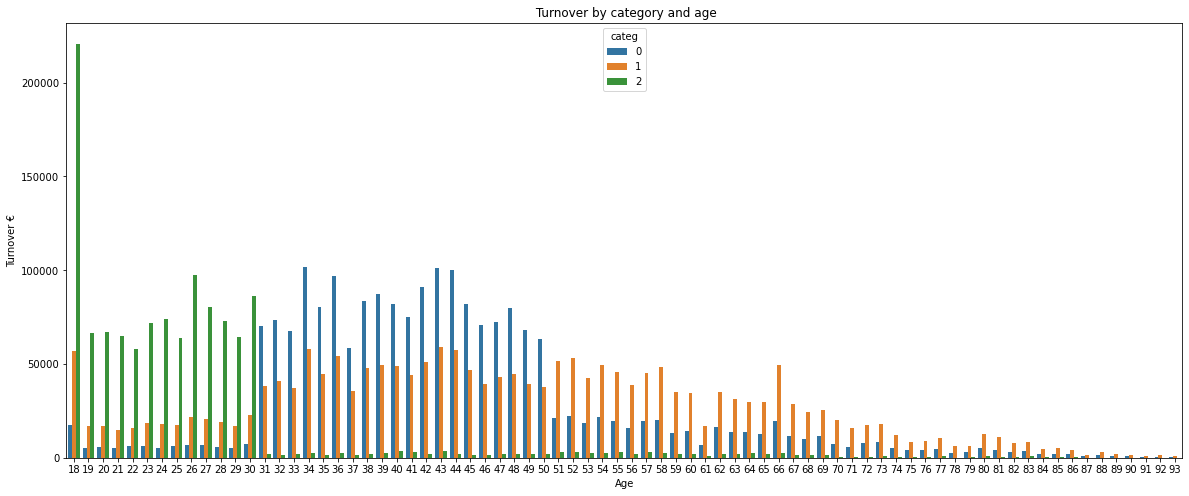

In [563]:
o=df.groupby(["age","categ"])['price'].sum().reset_index()
plt.figure(figsize = (20, 8))
g=sns.barplot(x='age', y='price', hue='categ', data=o)
g.set(xlabel="Age", ylabel = "Turnover €")
g.set_title(' Turnover by category and age')

Text(0.5, 1.0, 'Turnover by category and sex')

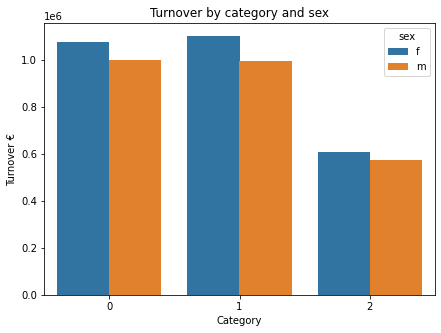

In [708]:
a=df.groupby(["sex","categ"])['price'].sum().reset_index()
plt.figure(figsize=(7,5))
g=sns.barplot(x='categ', y='price', hue='sex', data=a)
g.set(xlabel="Category", ylabel = "Turnover €")
g.set_xticklabels(["0", "1", "2"])
g.set_title('Turnover by category and sex')

Text(0, 0.5, 'Turnover €')

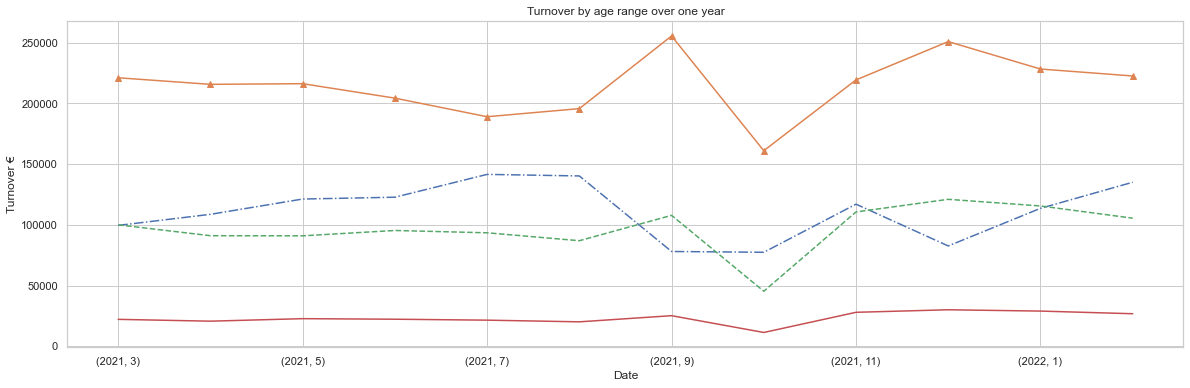

In [851]:
plt.figure(figsize = (20, 6))
df[(df['age']<30)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-.")
df[(df['age']>=30) & (df['age']<50)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="^-")
#df[(df['age']>=40) & (df['age']<50)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-.")
df[(df['age']>=50) & (df['age']<70)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="--")
#df[(df['age']>=60) & (df['age']<70)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="-.")
#df[(df['age']>=70) & (df['age']<80)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot(style="^-")
df[(df['age']>=70)].price.groupby([df.date.dt.year,df.date.dt.month]).sum().plot()
plt.title('Turnover by age range over one year')
plt.xlabel('Date')
plt.ylabel('Turnover €')

Text(0.5, 1.0, ' Turnover contribution by age')

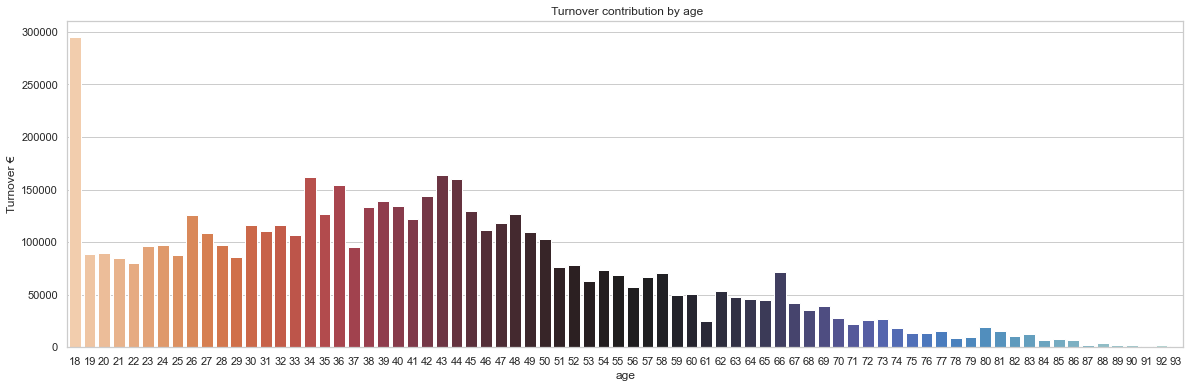

In [830]:
ca_age = df.groupby('age')['price'].sum().reset_index(name="Turnover")
plt.figure(figsize = (20, 6))
g=sns.barplot(x='age', y="Turnover", data=ca_age, palette='icefire_r')
g.set(xlabel="age", ylabel = "Turnover €")
g.set_title(' Turnover contribution by age')

-> those under 30 contribute more to the turnover than the 30-50 year-olds, although they buy much less than them but in view of the fact that they buy category 2 books which are considerably more expensive than those in the category 0

## Cart 

In [835]:
prod_panier=df.value_counts(subset=['session_id','client_id','sex','age']).reset_index(name="count")
prod_panier.head(5)

,session_id,client_id,sex,age,count
0,s_118668,c_5995,f,30,14
1,s_96857,c_5523,f,52,13
2,s_21005,c_8303,m,32,13
3,s_93892,c_8127,f,34,12
4,s_168560,c_7855,f,32,12


Text(0.5, 1.0, ' frequency of nb of product in cart by sex')

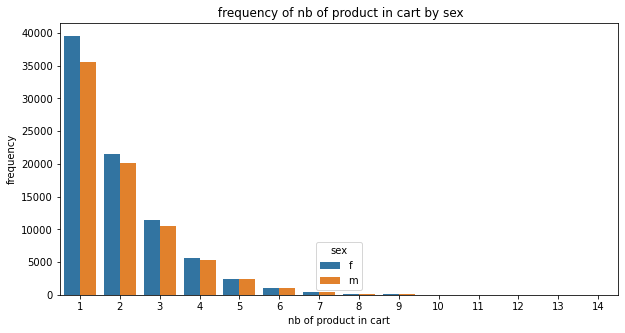

In [718]:
plt.figure(figsize = (10, 5))
g=sns.countplot(x='count', hue='sex', data=prod_panier)
g.set(xlabel="nb of product in cart", ylabel = "frequency")
g.set_title(' frequency of nb of product in cart by sex')

Text(0.5, 1.0, ' product mean in cart per age')

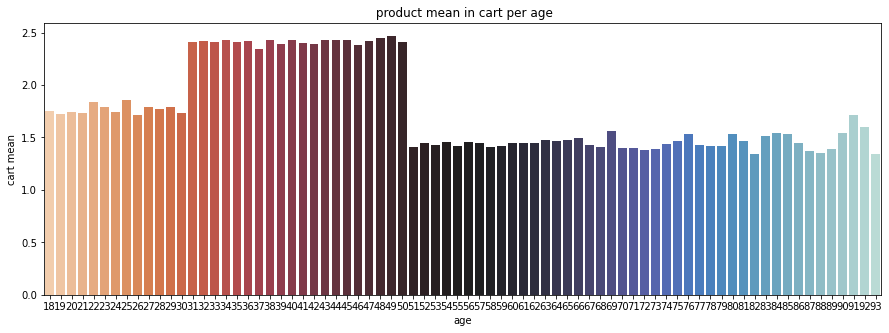

In [729]:
avg_panier = prod_panier.groupby('age')['count'].mean().reset_index(name="average")
plt.figure(figsize = (15, 5))
g=sns.barplot(x='age', y="average", data=avg_panier, palette='icefire_r')
g.set(xlabel="age", ylabel = "cart mean")
g.set_title(' product mean in cart per age')

In [859]:
sd=df.value_counts(subset=['session_id','age']).reset_index(name="nb_of_panier")
panier_total_age = pd.DataFrame(sd.groupby('age')['nb_of_panier'].sum()).reset_index()

Text(0.5, 1.0, ' nb of product in cart per age')

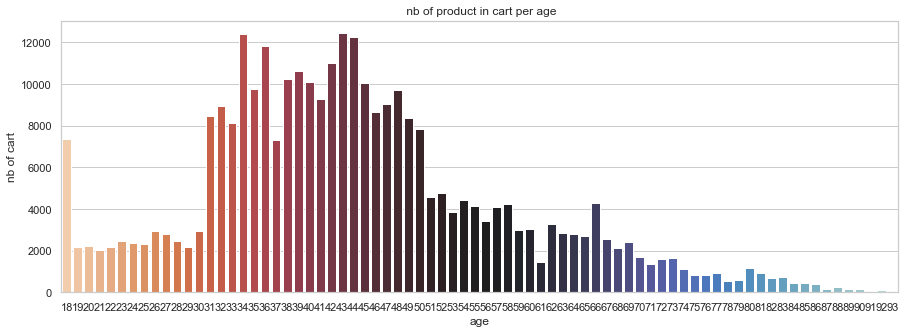

In [858]:
plt.figure(figsize = (15, 5))
g=sns.barplot(x='age', y="nb_of_panier", data=panier_total_age, palette='icefire_r')
g.set(xlabel="age", ylabel = "nb of cart")
g.set_title(' nb of product in cart per age')


## statistical test & correlation

### ->sex vs category

In [772]:
contingency = df[['sex','categ']].pivot_table(index='sex', columns='categ', aggfunc=len)
chi2, pvalue, degrees, expected = chi2_contingency(contingency)


In [774]:
chi2, pvalue, expected

(10.202417277273174,
 0.0060893822533516695,
 array([[101487.02774659,  53364.00501352,   8192.96723988],
        [ 93683.97225341,  49260.99498648,   7563.03276012]]))

<AxesSubplot:>

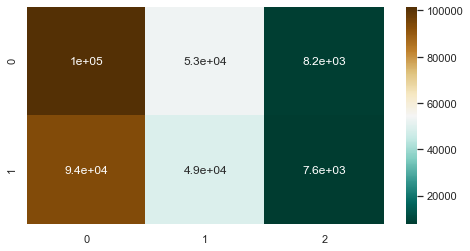

In [790]:
plt.figure(figsize=(8,4))
sns.set(style="whitegrid")
sns.heatmap(expected,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

-> after comparing the value of CHI2 with a degree of freedom of 2 and a pvalue of 0.5% one finds a value of 5.99 which is smaller than what we found, the hypothesis H0 is false so no correlation between sex and category and the graph confirms the result

### -> Age vs total purchase amount

In [862]:
a=df.groupby(['session_id','age'])['price'].sum().reset_index()
x= np.array(a.age)
y=np.array(a.price)
print(scipy.stats.pearsonr(x, y))
#print(scipy.stats.spearmanr(a.age, a.price))

(-0.33554541328509285, 0.0)


-> so there is correlation between age and total purchase amount, as we have seen previously, the under 30s buy books more expensive than others

### -> Age vs average cart size

In [865]:
avg_panier = prod_panier.groupby('age')['count'].mean().reset_index(name="average")
x= np.array(avg_panier.age)
y=np.array(avg_panier.average)
print(scipy.stats.pearsonr(x, y))

(-0.5945228620310373, 1.4923805316934926e-08)


-> so there is correlation between age and average cart size, 30-50 year olds have cart with several items, young people a little less and even less over 50s

### -> Age vs frequency of purchase per month

<AxesSubplot:xlabel='date', ylabel='age'>

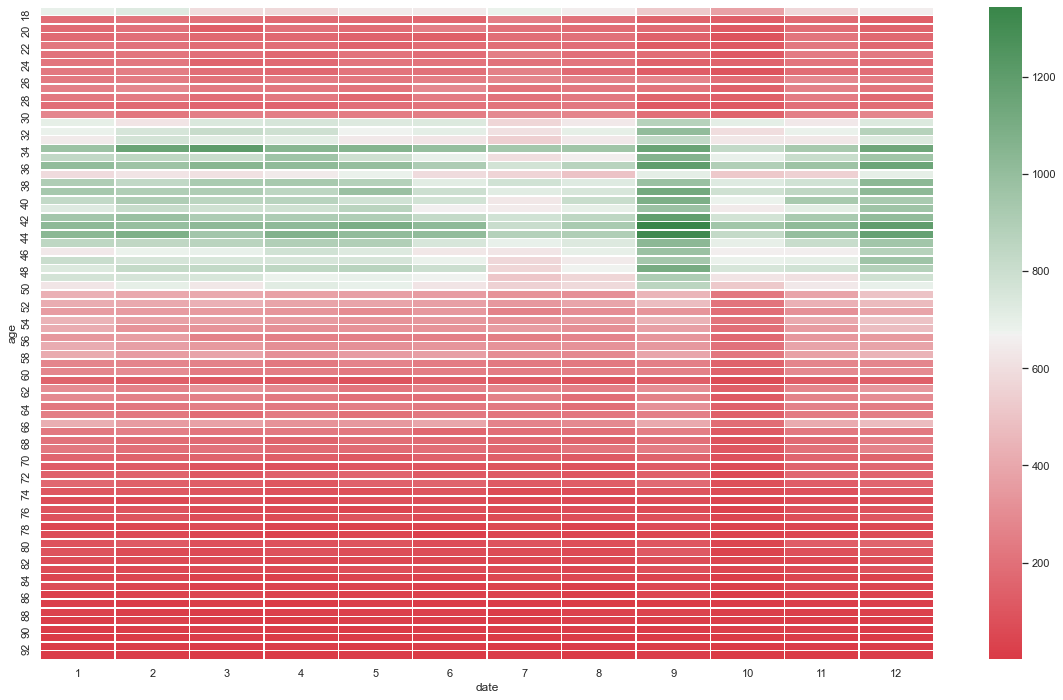

In [838]:
frequency = pd.pivot_table(df, values='id_prod', columns=df.date.dt.month,
                   index =['age'], aggfunc=len)
plt.figure(figsize=(20,12))
sns.set(style="whitegrid")
sns.heatmap(frequency,annot=False,linewidths=0.5,cmap=sns.diverging_palette(10, 133, as_cmap=True))

### ->Age vs category

In [870]:
df["age_mean"] = df['age'].mean()
age_moyen = df.groupby('categ')['age'].mean().reset_index()
age_moyen

,categ,age
0,0,43.799576
1,1,47.813856
2,2,25.751206


In [871]:
df["age_mean_categ"] = df.apply(lambda row : age_moyen.age[0] if row["categ"] == 0 else (age_moyen.age[1] if row["categ"] == 1 else age_moyen.age[2] ), axis=1)

In [872]:
Y1 = np.array(df['age'])
Y2 = np.array(df['age_mean'])
Y3 = np.array(df['age_mean_categ'])

In [873]:
intra = np.sum((Y1-Y3) ** 2) 
inter = np.sum((Y3-Y2) ** 2)
rapport = inter / (inter + intra)
print('coef of corr between age and category is {}'.format(rapport))

coef of corr between age and category is 0.11281696159847472


-> so there is correlation between age and category of books, as we have seen that category 2 is consumed most of the time by young people (-30), and category 0 mainly by 30-50

## Best seller

In [567]:
best_seller = df.value_counts(subset=['id_prod','price','categ']).reset_index(name="nb_of_sales")
best_seller['turnover']=best_seller['price'] * best_seller['nb_of_sales']
best_seller

,id_prod,price,categ,nb_of_sales,turnover
0,1_369,23.99,1,1015,24349.85
1,1_417,20.99,1,996,20906.04
2,1_414,23.83,1,966,23019.78
3,1_498,23.37,1,955,22318.35
4,1_425,16.99,1,941,15987.59
...,...,...,...,...,...
3256,0_1120,21.84,0,1,21.84
3257,0_94,27.76,0,1,27.76
3258,2_23,115.99,2,1,115.99
3259,0_1462,31.67,0,1,31.67


Text(0, 0.5, 'frequency')

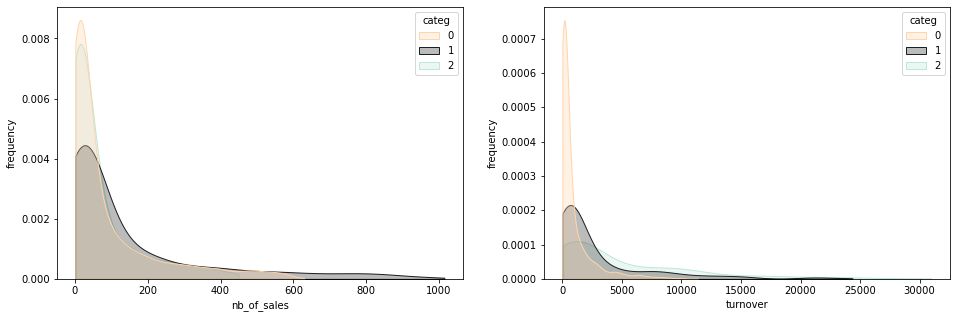

In [568]:
f, ax = plt.subplots(1,2,figsize=(16,5))
sns.kdeplot(data=best_seller ,x="nb_of_sales", hue="categ",cut=0 ,fill=True, palette='icefire_r',common_norm=False, alpha =0.3,ax=ax[0])
ax[0].set_xlabel('nb_of_sales')
ax[0].set_ylabel('frequency')
sns.kdeplot(data=best_seller ,x="turnover", hue="categ",cut=0 ,fill=True, palette='icefire_r',common_norm=False, alpha =0.3,ax=ax[1])
ax[1].set_xlabel('turnover')
ax[1].set_ylabel('frequency')